In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
from networkx.algorithms.community import greedy_modularity_communities

In [5]:
# ============== Load data ==============
scientists_df = pd.read_csv('../output/scientists_cleaned.csv')
papers_df = pd.read_csv('../output/papers_cleaned.csv')

In [6]:
# ============== Normalize names ==============
input_names = set(scientists_df['name'].str.lower().str.strip())

In [7]:
# ============== Filter valid authors in papers ==============
def filter_authors(authors):
    try:
        authors = [a.lower().strip() for a in authors.split(',')]  # Handle comma-separated string
        return [a for a in authors if a in input_names]
    except Exception as e:
        print(f"Error processing authors: {e}")
        return []

In [8]:
papers_df['valid_authors'] = papers_df['Authors'].apply(filter_authors)
print(papers_df[['Title', 'valid_authors']].head())
papers_df = papers_df[papers_df['valid_authors'].apply(len) >= 2]

                                               Title valid_authors
0        A multi-level approach to data base design.            []
1          An Overview of Recent Data Base Research.            []
2  Survey of Recent Operating Systems Research, D...            []
3  Distributed data base management: Some thought...            []
4  Lexical Relations: Enhancing Effectiveness of ...            []


In [9]:
# ============== Build graph ==============
G = nx.Graph()
G.add_nodes_from(input_names)

In [10]:
for _, row in papers_df.iterrows():
    for a1, a2 in combinations(row['valid_authors'], 2):
        if G.has_edge(a1, a2):
            G[a1][a2]['weight'] += 1
        else:
            G.add_edge(a1, a2, weight=1)

In [11]:
# ============== Network properties ==============
print("=== Network Properties ===")
print(f"Total Nodes (in input list): {G.number_of_nodes()}")
print(f"Total Edges: {G.number_of_edges()}")
print(f"Average Degree: {np.mean([deg for _, deg in G.degree()]):.2f}")
print(f"Network Density: {nx.density(G):.4f}")
print(f"Number of Connected Components: {nx.number_connected_components(G)}")
print(f"Average Clustering Coefficient: {nx.average_clustering(G):.4f}")

=== Network Properties ===
Total Nodes (in input list): 1039
Total Edges: 4720
Average Degree: 9.09
Network Density: 0.0088
Number of Connected Components: 287
Average Clustering Coefficient: 0.2684


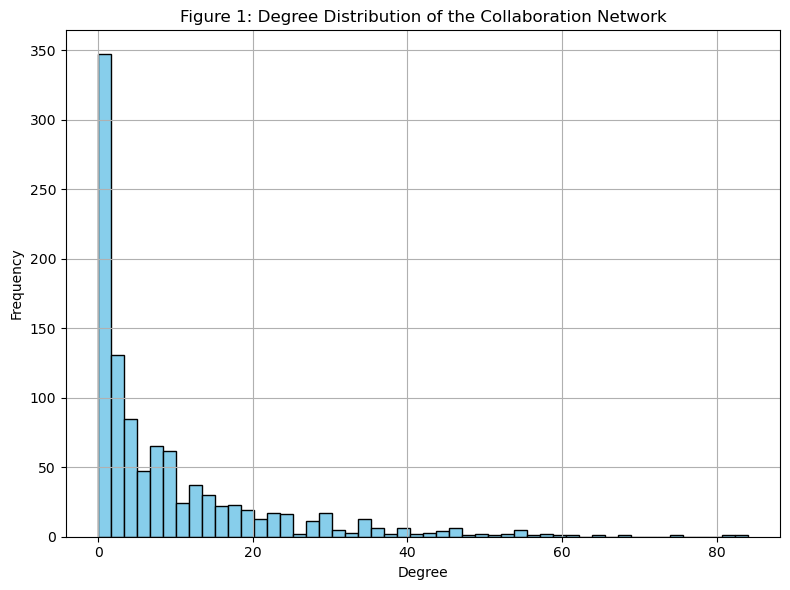

In [12]:
# ============== Figure 1: Degree Distribution ==============
degrees = [deg for node, deg in G.degree()]
plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=50, color='skyblue', edgecolor='black')
plt.title("Figure 1: Degree Distribution of the Collaboration Network")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()

In [13]:
# ============== Figure 2: Giant Component ==============
giant_component = max(nx.connected_components(G), key=len)
G_giant = G.subgraph(giant_component)

In [14]:
print("\n=== Giant Component Properties ===")
print(f"Nodes in Giant Component: {G_giant.number_of_nodes()}")
print(f"Edges in Giant Component: {G_giant.number_of_edges()}")
if nx.is_connected(G_giant):
    print(f"Diameter: {nx.diameter(G_giant)}")
    print(f"Average Shortest Path Length: {nx.average_shortest_path_length(G_giant):.2f}")
else:
    print("Giant component is not fully connected (unexpected).")
# Find isolated nodes (nodes that are not in the giant component)
isolated_nodes = list(set(G.nodes()) - set(giant_component))
print(f"Number of Isolated Nodes: {len(isolated_nodes)}")


=== Giant Component Properties ===
Nodes in Giant Component: 747
Edges in Giant Component: 4712
Diameter: 9
Average Shortest Path Length: 3.23
Number of Isolated Nodes: 292


/var/folders/0y/926bml0x27j90kg_6jr1s2h00000gn/T/ipykernel_51716/1958320033.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


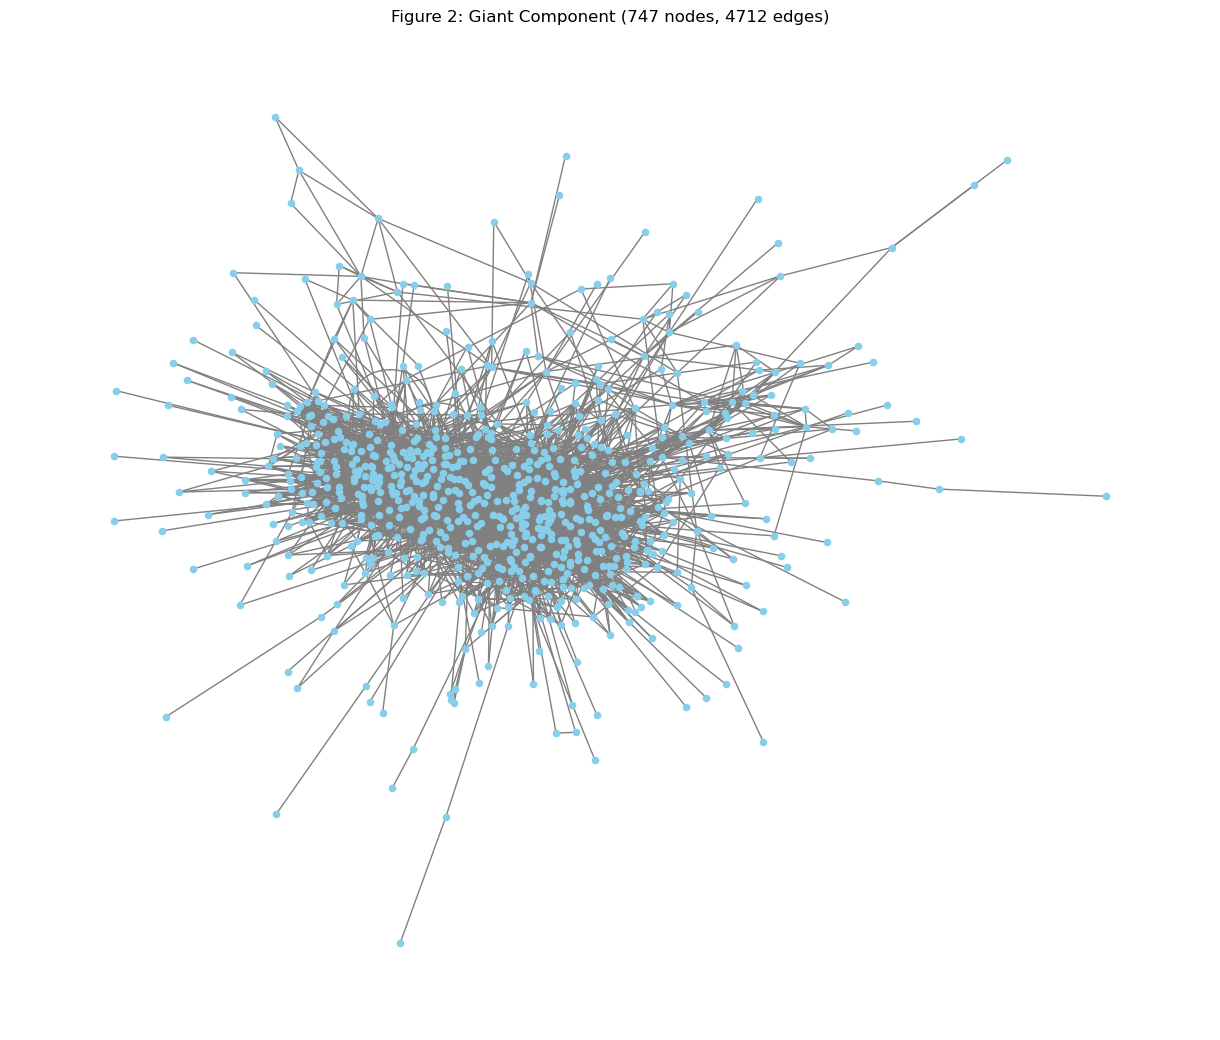

In [15]:
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_giant, seed=42)
nx.draw(G_giant, pos, node_size=20, edge_color='gray', node_color='skyblue', with_labels=False)
plt.title(f"Figure 2: Giant Component ({G_giant.number_of_nodes()} nodes, {G_giant.number_of_edges()} edges)")
plt.tight_layout()

In [16]:
# ============== Figure 3: Largest Clique ==============
cliques = list(nx.find_cliques(G))
largest_clique = max(cliques, key=len)
G_clique = G.subgraph(largest_clique)

/var/folders/0y/926bml0x27j90kg_6jr1s2h00000gn/T/ipykernel_51716/3242246811.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


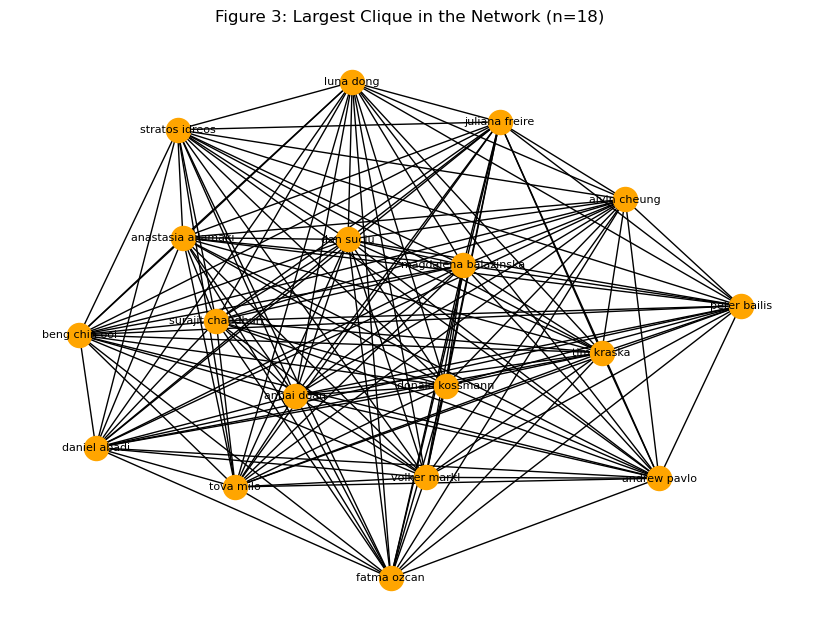

In [17]:
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_clique, seed=42)  # Changed layout for better visualization
nx.draw(G_clique, pos, with_labels=True, node_color='orange', edge_color='black', node_size=300, font_size=8)
plt.title(f"Figure 3: Largest Clique in the Network (n={len(largest_clique)})")
plt.tight_layout()

In [18]:
#============== Figure 4: Degree Centrality vs Degree ==============
degree_centrality = nx.degree_centrality(G)
degrees_dict = dict(G.degree())
x = list(degrees_dict.values())
y = [degree_centrality[node] for node in degrees_dict]

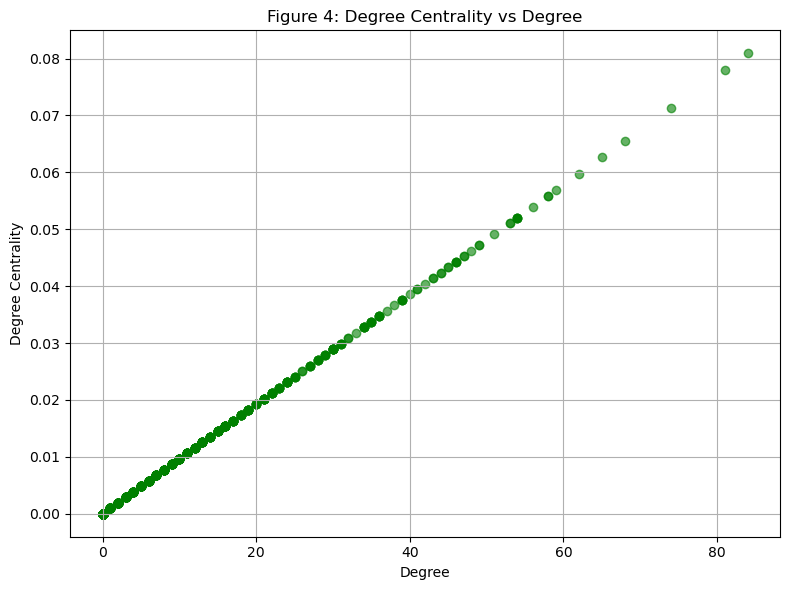

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='green', alpha=0.6)
plt.title("Figure 4: Degree Centrality vs Degree")
plt.xlabel("Degree")
plt.ylabel("Degree Centrality")
plt.grid(True)
plt.tight_layout()

In [20]:
# ============== Figure 5: Degree Centrality vs Betweenness Centrality  ==============
betweenness_centrality = nx.betweenness_centrality(G)
x = [degree_centrality[node] for node in G.nodes()]
y = [betweenness_centrality[node] for node in G.nodes()]

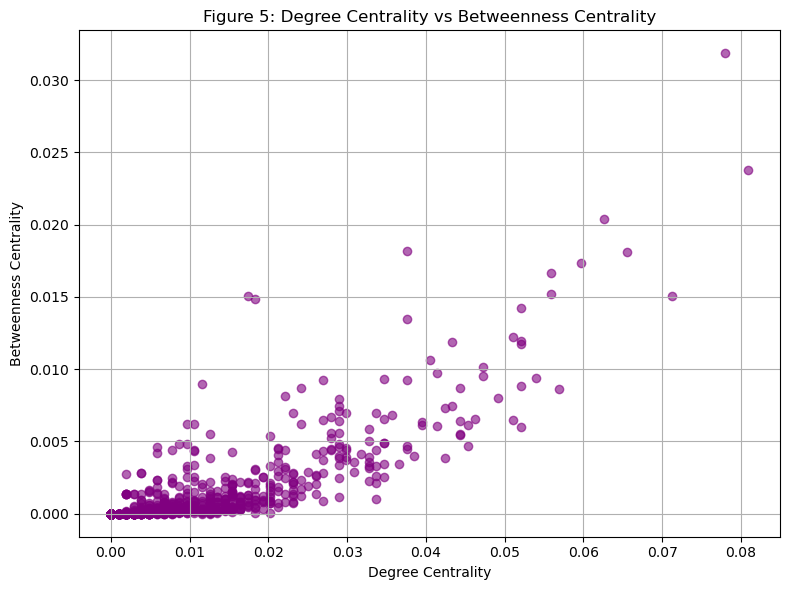

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='purple', alpha=0.6)
plt.title("Figure 5: Degree Centrality vs Betweenness Centrality")
plt.xlabel("Degree Centrality")
plt.ylabel("Betweenness Centrality")
plt.grid(True)
plt.tight_layout()

In [22]:
# ============ Top 10 Most Central Scientists  ==============
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\n=== Top 10 Most Central Scientists (Betweenness Centrality) ===")
for name, centrality in top_betweenness:
    print(f"{name.title()}: {centrality:.4f}")


=== Top 10 Most Central Scientists (Betweenness Centrality) ===
Divesh Srivastava: 0.0319
Beng Chin Ooi: 0.0238
Rui Zhang: 0.0204
Elisa Bertino: 0.0182
Haixun Wang: 0.0181
Felix Naumann: 0.0174
Juliana Freire: 0.0167
Ce Zhang: 0.0152
Arnab Bhattacharya: 0.0151
Wei Wang: 0.0151


In [23]:
# ============ Figure 6 Ego Network ==============
central_person = max(betweenness_centrality, key=betweenness_centrality.get)
central_node_degree = G.degree(central_person)
all_node_degrees = dict(G.degree())
ego_network = nx.ego_graph(G, central_person)
ego_network_size = len(ego_network.nodes)

/var/folders/0y/926bml0x27j90kg_6jr1s2h00000gn/T/ipykernel_51716/1602267479.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


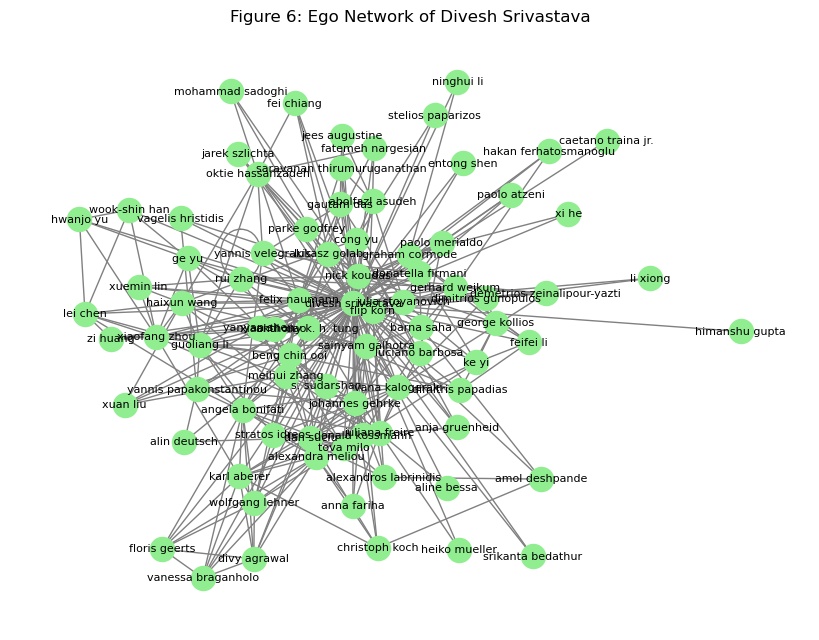

In [24]:
plt.figure(figsize=(8, 6))
pos_ego = nx.spring_layout(ego_network)
nx.draw(ego_network, pos_ego, with_labels=True, node_color='lightgreen', edge_color='gray', node_size=300, font_size=8)
plt.title(f"Figure 6: Ego Network of {central_person.title()}")
plt.tight_layout()


In [25]:
print(f"The central node is: {central_person.title()}")
print(f"The degree of the central node is: {central_node_degree}")
print(f"The number of nodes in the ego network of {central_person.title()} is: {ego_network_size}")

The central node is: Divesh Srivastava
The degree of the central node is: 81
The number of nodes in the ego network of Divesh Srivastava is: 82
